In [1]:
pip install yfinance

In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=e66c2295476397ef54b487243263a5170513914b8eb070143ac98caa56cbb94a
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import ta
import pandas as pd
import yfinance as yf

In [6]:
def calculate_technical_indicators(stock_df):
    C = stock_df['Close']
    H = stock_df['High']
    L = stock_df['Low']
    V = stock_df['Volume']

    # Calculate RSI
    stock_df['RSI'] = ta.momentum.RSIIndicator(close=C, window=14).rsi()

    # Calculate MACD
    macd = ta.trend.MACD(close=C, window_slow=26, window_fast=12, window_sign=9)
    stock_df['MACD'] = macd.macd()

    # Calculate Moving Averages
    stock_df['SMA_20'] = C.rolling(window=20).mean()
    stock_df['SMA_50'] = C.rolling(window=50).mean()

    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=C, window=20, window_dev=2)
    stock_df['BB_High'] = bollinger.bollinger_hband()
    stock_df['BB_Low'] = bollinger.bollinger_lband()

    stock_df['BB_Width'] = stock_df['BB_High'] - stock_df['BB_Low']
    stock_df['Price_Position'] = (stock_df['Close'] - stock_df['BB_Low']) / (stock_df['BB_High'] - stock_df['BB_Low'])
    stock_df['BB_Cross_Above'] = ((stock_df['Close'].shift(1) <= stock_df['BB_High'].shift(1)) &
                               (stock_df['Close'] > stock_df['BB_High'])).astype(int)
    stock_df['BB_Cross_Below'] = ((stock_df['Close'].shift(1) >= stock_df['BB_Low'].shift(1)) &
                               (stock_df['Close'] < stock_df['BB_Low'])).astype(int)
    stock_df['BB_Tightening'] = (stock_df['BB_Width'] < stock_df['BB_Width'].rolling(window=20).mean() * 0.8).astype(int)
    stock_df['BB_Widening'] = (stock_df['BB_Width'] > stock_df['BB_Width'].rolling(window=20).mean() * 1.2).astype(int)
    stock_df['Touch_Upper_Band'] = (stock_df['Close'] >= stock_df['BB_High']).astype(int)
    stock_df['Touch_Lower_Band'] = (stock_df['Close'] <= stock_df['BB_Low']).astype(int)
    stock_df['Momentum_Divergence'] = (stock_df['RSI'].diff() * stock_df['Close'].diff()).apply(lambda x: 1 if x < 0 else 0)


    # Calculate Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(high=H, low=L, close=C, window=14, smooth_window=3)
    stock_df['Stoch_K'] = stoch.stoch()
    stock_df['Stoch_D'] = stoch.stoch_signal()

    return stock_df


In [35]:
from sklearn.preprocessing import StandardScaler
sectors = {
    "Consumer Staples": ["KO", "PG", "WMT", "PEP", "MO"],
    "Consumer Discretionary": ["AMZN", "TSLA", "HD", "MCD", "NKE","HESAY"],
    "Energy": ["XOM", "CVX", "BP", "SLB", "COP"],
    "Financials": ["JPM", "BAC", "WFC", "GS", "MS"],
    "Health Care": ["JNJ", "PFE", "MRK", "UNH", "ABBV"],
    "Industrials": ["BA", "GE", "CAT", "UPS", "MMM"],
    "Information Technology": ["AAPL", "MSFT", "GOOGL", "META", "NVDA", "NFLX", "AMZN", "TSLA"],
    "Materials": ["LIN", "APD", "NEM", "ECL", "DD"],
    "Real Estate": ["PLD", "AMT", "SPG", "WELL", "EQIX"],
    "Utilities": ["NEE", "DUK", "SO", "AEP", "EXC"],
    "Telecommunication Services": ["T", "VZ", "TMUS", "CHTR"],
    # "Volatile": ["QS","NIO","OPEN","RUN",'MP','COIN','HRI','OVV','FLR','PLTR','CLF','TSLA']
}
stock_codes = sectors["Information Technology"]  # Example stock codes
all_stocks_df = pd.DataFrame()

# Fetch historical data from 2015 to mid-2024
start_date = "2015-01-01"
end_date = "2024-06-30"

for code in stock_codes:
    # Fetch historical data from 2015 to mid-2024
    stock_df = yf.download(code, start=start_date, end=end_date).reset_index()
    stock_df['Stock'] = code  # Add a column for the stock code
    # Calculate technical indicators
    stock_df = calculate_technical_indicators(stock_df)

    # Concatenate the resulting DataFrame into the all_stocks_df
    all_stocks_df = pd.concat([all_stocks_df, stock_df], ignore_index=True)

# Fetch S&P 500 index data
snp = yf.download(tickers='^GSPC', start=start_date, end=end_date).reset_index()
snp = snp[['Date', 'Close']].rename(columns={'Close': 'SNP_Close'})

# Merge S&P 500 index data with all_stocks_df
all_stocks_df = pd.merge(all_stocks_df, snp, on='Date', how='left')

# Define features to scale
features_to_scale = ['Close', 'Volume', 'RSI', 'MACD', 'SMA_20', 'BB_High', 'Stoch_K']

# Display the first few rows of the scaled DataFrame
all_stocks_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Stock,RSI,MACD,...,BB_Cross_Above,BB_Cross_Below,BB_Tightening,BB_Widening,Touch_Upper_Band,Touch_Lower_Band,Momentum_Divergence,Stoch_K,Stoch_D,SNP_Close
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.435274,212818400,AAPL,NaN,NaN,...,0,0,0,0,0,0,0,NaN,NaN,2058.199951
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.746893,257142000,AAPL,NaN,NaN,...,0,0,0,0,0,0,0,NaN,NaN,2020.579956
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.749126,263188400,AAPL,NaN,NaN,...,0,0,0,0,0,0,0,NaN,NaN,2002.609985
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.082136,160423600,AAPL,NaN,NaN,...,0,0,0,0,0,0,0,NaN,NaN,2025.900024
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.007435,237458000,AAPL,NaN,NaN,...,0,0,0,0,0,0,0,NaN,NaN,2062.139893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19043,2024-06-12,171.119995,180.550003,169.800003,177.289993,177.289993,90389400,TSLA,51.914947,0.237765,...,0,0,1,0,0,0,0,64.744385,31.942570,5421.029785
19044,2024-06-13,188.389999,191.080002,181.229996,182.470001,182.470001,118984100,TSLA,56.714006,0.754789,...,0,0,1,0,0,0,0,63.624836,49.399462,5433.740234
19045,2024-06-14,185.800003,186.000000,176.919998,178.009995,178.009995,82038200,TSLA,51.910170,0.795479,...,0,0,1,0,0,0,0,44.782390,57.717204,5431.600098
19046,2024-06-17,177.919998,188.809998,177.000000,187.440002,187.440002,109786100,TSLA,59.685522,1.570545,...,1,0,0,0,1,0,0,84.621886,64.343037,5473.229980


In [36]:
all_stocks_df.dropna(inplace=True)

In [37]:
all_stocks_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Stock',
       'RSI', 'MACD', 'SMA_20', 'SMA_50', 'BB_High', 'BB_Low', 'BB_Width',
       'Price_Position', 'BB_Cross_Above', 'BB_Cross_Below', 'BB_Tightening',
       'BB_Widening', 'Touch_Upper_Band', 'Touch_Lower_Band',
       'Momentum_Divergence', 'Stoch_K', 'Stoch_D', 'SNP_Close'],
      dtype='object')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Percentage of times the stock price increased the next day after high RSI for each stock:
Stock
AAPL     52.500000
AMZN     58.064516
GOOGL    78.947368
META     72.340426
MSFT     55.555556
NFLX     47.500000
NVDA     60.714286
TSLA     61.764706
Name: Increase, dtype: float64
    Stock       Date  Price_Today  Price_Next_Day  Increase
0    AAPL 2015-07-09    30.017500       30.820000      True
1    AAPL 2015-08-04    28.660000       28.850000      True
2    AAPL 2015-08-05    28.850000       28.782499     False
3    AAPL 2015-08-06    28.782499       28.879999      True
4    AAPL 2015-08-24    25.780001       25.934999      True
..    ...        ...          ...             ...       ...
277  TSLA 2024-02-01   188.860001      187.910004     False
278  TSLA 2024-02-05   181.059998      185.100006      True
279  TSLA 2024-02-06   185.100006      187.580002      True
280  TSLA 2024-03-14   162.500000      163.570007      True
281  TSLA 2024-04-22   142.050003      144.679993      True



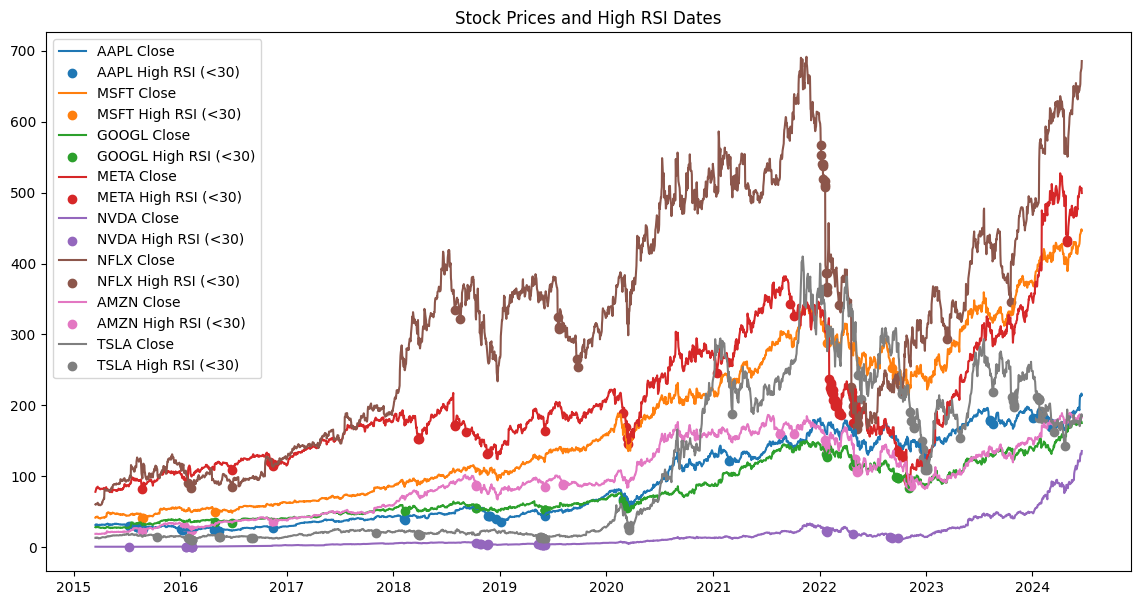

In [11]:
import yfinance as yf
import pandas as pd
import ta  # Library for technical analysis
import matplotlib.pyplot as plt

# Define stock codes for Information Technology sector

stock_codes = sectors["Information Technology"]  # Example stock codes

# Initialize empty DataFrame
all_stocks_df = pd.DataFrame()

# Fetch historical data from 2015 to mid-2024
start_date = "2015-01-01"
end_date = "2024-06-30"

for code in stock_codes:
    stock_df = yf.download(code, start=start_date, end=end_date).reset_index()
    stock_df['Stock'] = code  # Add a column for the stock code
    # Calculate technical indicators
    stock_df = calculate_technical_indicators(stock_df)
    # Concatenate the resulting DataFrame into the all_stocks_df
    all_stocks_df = pd.concat([all_stocks_df, stock_df], ignore_index=True)

# Ensure Date column is in datetime format
all_stocks_df['Date'] = pd.to_datetime(all_stocks_df['Date'])

# Drop any rows with NaN values
all_stocks_df.dropna(inplace=True)

# Select dates with high RSI (over 55) for each stock
low_rsi_dates = all_stocks_df[all_stocks_df['RSI'] <= 30].index

# Check if the stock price is higher the next day
results = []
for idx in low_rsi_dates:
    stock = all_stocks_df.loc[idx, 'Stock']
    date = all_stocks_df.loc[idx, 'Date']
    next_day = date + pd.Timedelta(days=1)

    # Ensure next day exists in the data for the same stock
    if next_day in all_stocks_df[(all_stocks_df['Stock'] == stock)]['Date'].values:
        price_today = all_stocks_df.loc[idx, 'Close']
        price_next_day = all_stocks_df[(all_stocks_df['Stock'] == stock) & (all_stocks_df['Date'] == next_day)]['Close'].values[0]
        results.append((stock, date, price_today, price_next_day, price_next_day > price_today))

# Convert results to DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['Stock', 'Date', 'Price_Today', 'Price_Next_Day', 'Increase'])

# Calculate the percentage of times the price increased for each stock
percentage_increase = results_df.groupby('Stock')['Increase'].mean() * 100

# Print the results
print(f"Percentage of times the stock price increased the next day after high RSI for each stock:\n{percentage_increase}")
print(results_df)

# Visualize the results
plt.figure(figsize=(14, 7))
for stock in all_stocks_df['Stock'].unique():
    stock_data = all_stocks_df[all_stocks_df['Stock'] == stock]
    plt.plot(stock_data['Date'], stock_data['Close'], label=f'{stock} Close')
    high_rsi_stock_data = results_df[results_df['Stock'] == stock]
    plt.scatter(high_rsi_stock_data['Date'], high_rsi_stock_data['Price_Today'], label=f'{stock} High RSI (<30)', marker='o')
plt.title('Stock Prices and High RSI Dates')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


KeyError: 'SMA_5'

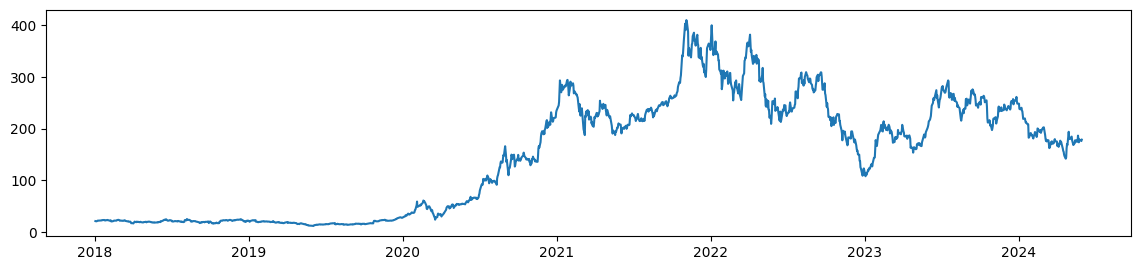

In [12]:
# Load your stock data (example: using yfinance to get stock data)
ticker = "TSLA"  # Example stock ticker
start_date = "2018-01-01"
end_date = "2024-05-31"

stock_df = yf.download(ticker, start=start_date, end=end_date)
stock_df = calculate_technical_indicators(stock_df)

# Plotting the stock price and technical indicators
plt.figure(figsize=(14, 10))

# Plot the closing price
plt.subplot(3, 1, 1)
plt.plot(stock_df.index, stock_df['Close'], label='Close')
plt.plot(stock_df.index, stock_df['SMA_5'], label='SMA 5')
plt.plot(stock_df.index, stock_df['SMA_10'], label='SMA 10')
plt.plot(stock_df.index, stock_df['SMA_20'], label='SMA 20')
plt.plot(stock_df.index, stock_df['SMA_60'], label='SMA 60')
plt.title('Stock Price and Moving Averages')
plt.legend()

# Plot the RSI
plt.subplot(3, 1, 2)
plt.plot(stock_df.index, stock_df['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# Plot the MACD
plt.subplot(3, 1, 3)
plt.plot(stock_df.index, stock_df['MACD'], label='MACD')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.legend()

plt.tight_layout()
plt.show()

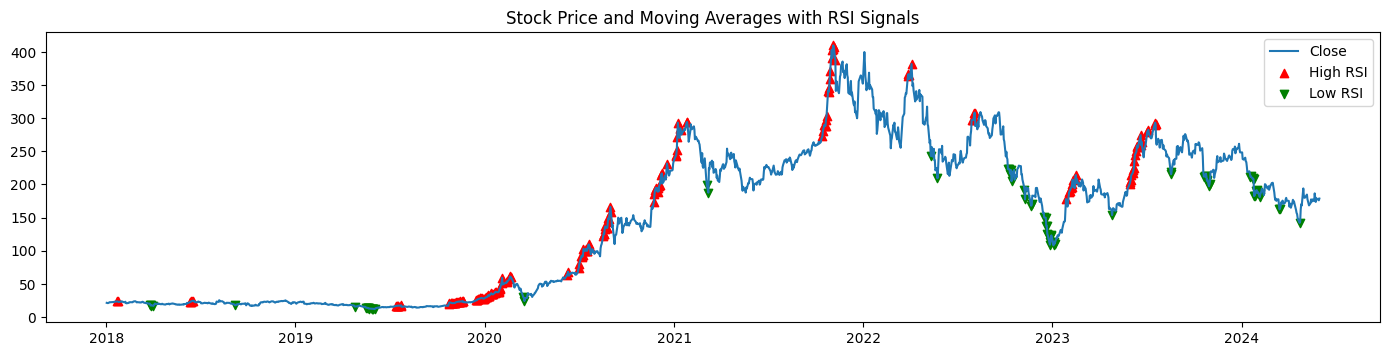

In [13]:
# Calculate technical indicators
stock_df = calculate_technical_indicators(stock_df)

# Identify high and low RSI dates
high_rsi_dates = stock_df[stock_df['RSI'] > 70].index
low_rsi_dates = stock_df[stock_df['RSI'] < 30].index

# Plotting the stock price and technical indicators
plt.figure(figsize=(14, 10))

# Plot the closing price
plt.subplot(3, 1, 1)
plt.plot(stock_df.index, stock_df['Close'], label='Close')


# Mark high RSI dates
plt.scatter(high_rsi_dates, stock_df.loc[high_rsi_dates]['Close'], color='red', marker='^', label='High RSI')

# Mark low RSI dates
plt.scatter(low_rsi_dates, stock_df.loc[low_rsi_dates]['Close'], color='green', marker='v', label='Low RSI')

plt.title('Stock Price and Moving Averages with RSI Signals')
plt.legend()


plt.tight_layout()
plt.show()

Percentage of times the stock price increased the next day after high MACD: 52.27%
          Date  Price_Today  Price_Next_Day  Increase
0   2018-02-07    23.000000       21.015333     False
1   2018-02-08    21.015333       20.694668     False
2   2018-02-26    23.827999       23.399332     False
3   2018-02-27    23.399332       22.870667     False
4   2018-02-28    22.870667       22.062000     False
..         ...          ...             ...       ...
655 2024-05-21   186.600006      180.110001     False
656 2024-05-22   180.110001      173.740005     False
657 2024-05-23   173.740005      179.240005      True
658 2024-05-28   176.750000      176.190002     False
659 2024-05-29   176.190002      178.789993      True

[660 rows x 4 columns]


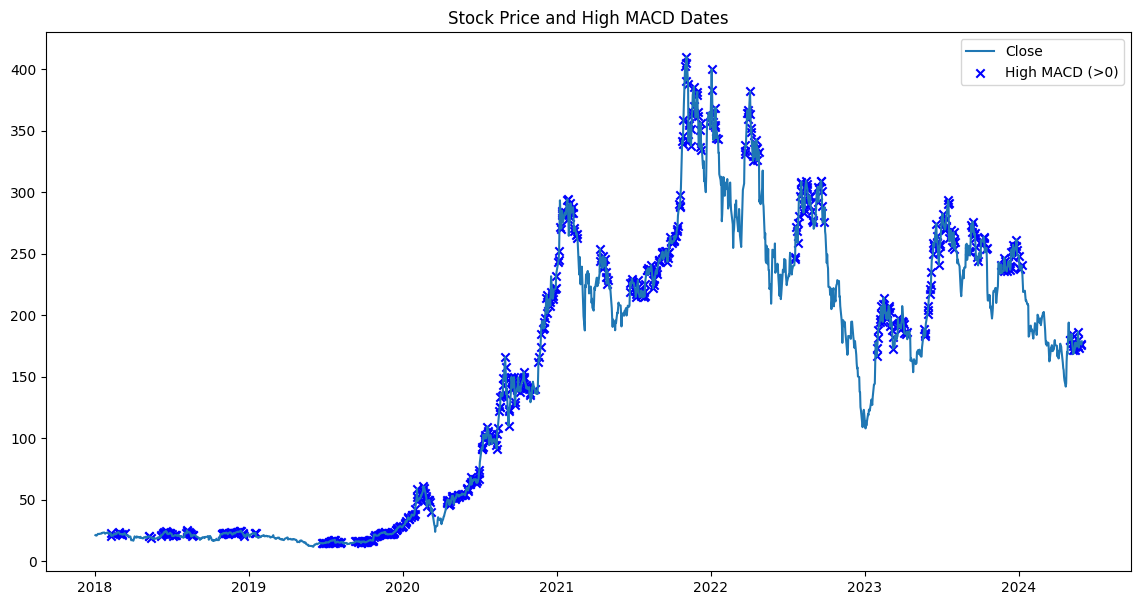

In [14]:
# Select dates with high MACD (example threshold: MACD > 0)
high_macd_dates = stock_df[stock_df['MACD'] > 0].index
# Check if the stock price is higher the next day
results = []
for date in high_macd_dates:
    if date + pd.Timedelta(days=1) in stock_df.index:
        price_today = stock_df.loc[date, 'Close']
        price_next_day = stock_df.loc[date + pd.Timedelta(days=1), 'Close']
        results.append((date, price_today, price_next_day, price_next_day > price_today))

# Convert results to DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['Date', 'Price_Today', 'Price_Next_Day', 'Increase'])

# Calculate the percentage of times the price increased
percentage_increase = results_df['Increase'].mean() * 100

# Print the results
print(f"Percentage of times the stock price increased the next day after high MACD: {percentage_increase:.2f}%")
print(results_df)
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(stock_df.index, stock_df['Close'], label='Close')
plt.scatter(results_df['Date'], results_df['Price_Today'], color='blue', label='High MACD (>0)', marker='x')
plt.title('Stock Price and High MACD Dates')
plt.legend()
plt.show()

In [ ]:
high_macd_dates.shape

(849,)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Consumer Staples: 0.012702030054283012
Consumer Discretionary: 0.02013264802474903
Energy: 0.02161989378768787
Financials: 0.019208701601017498
Health Care: 0.01468034742201239
Industrials: 0.01987630764759353
Information Technology: 0.024176003197240205
Materials: 0.01792659991002158
Real Estate: 0.019048800399348125
Utilities: 0.014382539679302786
Telecommunication Services: 0.015833619105634585
The sector with the most up and down movements is: Information Technology


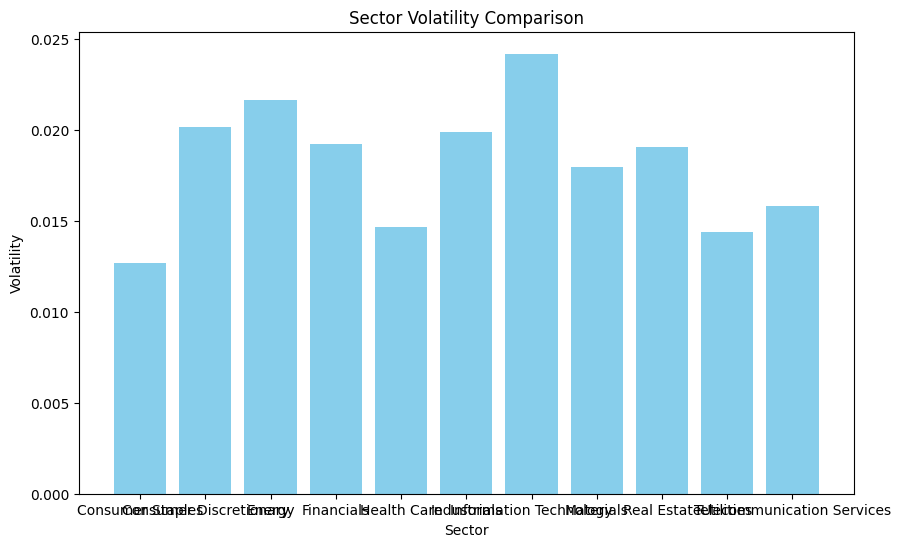

In [15]:
import yfinance as yf
import pandas as pd

# 데이터 다운로드 기간 설정
start_date = '2015-06-01'
end_date = '2024-05-31'

# 섹터별 변동성 계산
sector_volatility = {}

for sector, stocks in sectors.items():
    sector_returns = []
    for stock in stocks:
        # 주식 데이터 다운로드
        df = yf.download(stock, start=start_date, end=end_date)

        # 일간 수익률 계산
        df['Daily Return'] = df['Close'].pct_change()

        # 수익률 리스트에 추가
        sector_returns.append(df['Daily Return'].dropna())

    # 섹터 전체의 일간 수익률 합치기
    sector_returns = pd.concat(sector_returns, axis=1)

    # 섹터의 변동성(일간 수익률의 표준편차) 계산
    sector_volatility[sector] = sector_returns.std().mean()

# 섹터별 변동성 출력
for sector, volatility in sector_volatility.items():
    print(f"{sector}: {volatility}")

# 가장 변동성이 높은(가장 균형 잡힌) 섹터 찾기
max_volatility_sector = max(sector_volatility, key=sector_volatility.get)
print(f"The sector with the most up and down movements is: {max_volatility_sector}")

# 변동성 시각화
sectors = list(sector_volatility.keys())
volatilities = list(sector_volatility.values())

plt.figure(figsize=(10, 6))
plt.bar(sectors, volatilities, color='skyblue')
plt.xlabel('Sector')
plt.ylabel('Volatility')
plt.title('Sector Volatility Comparison')
plt.show()


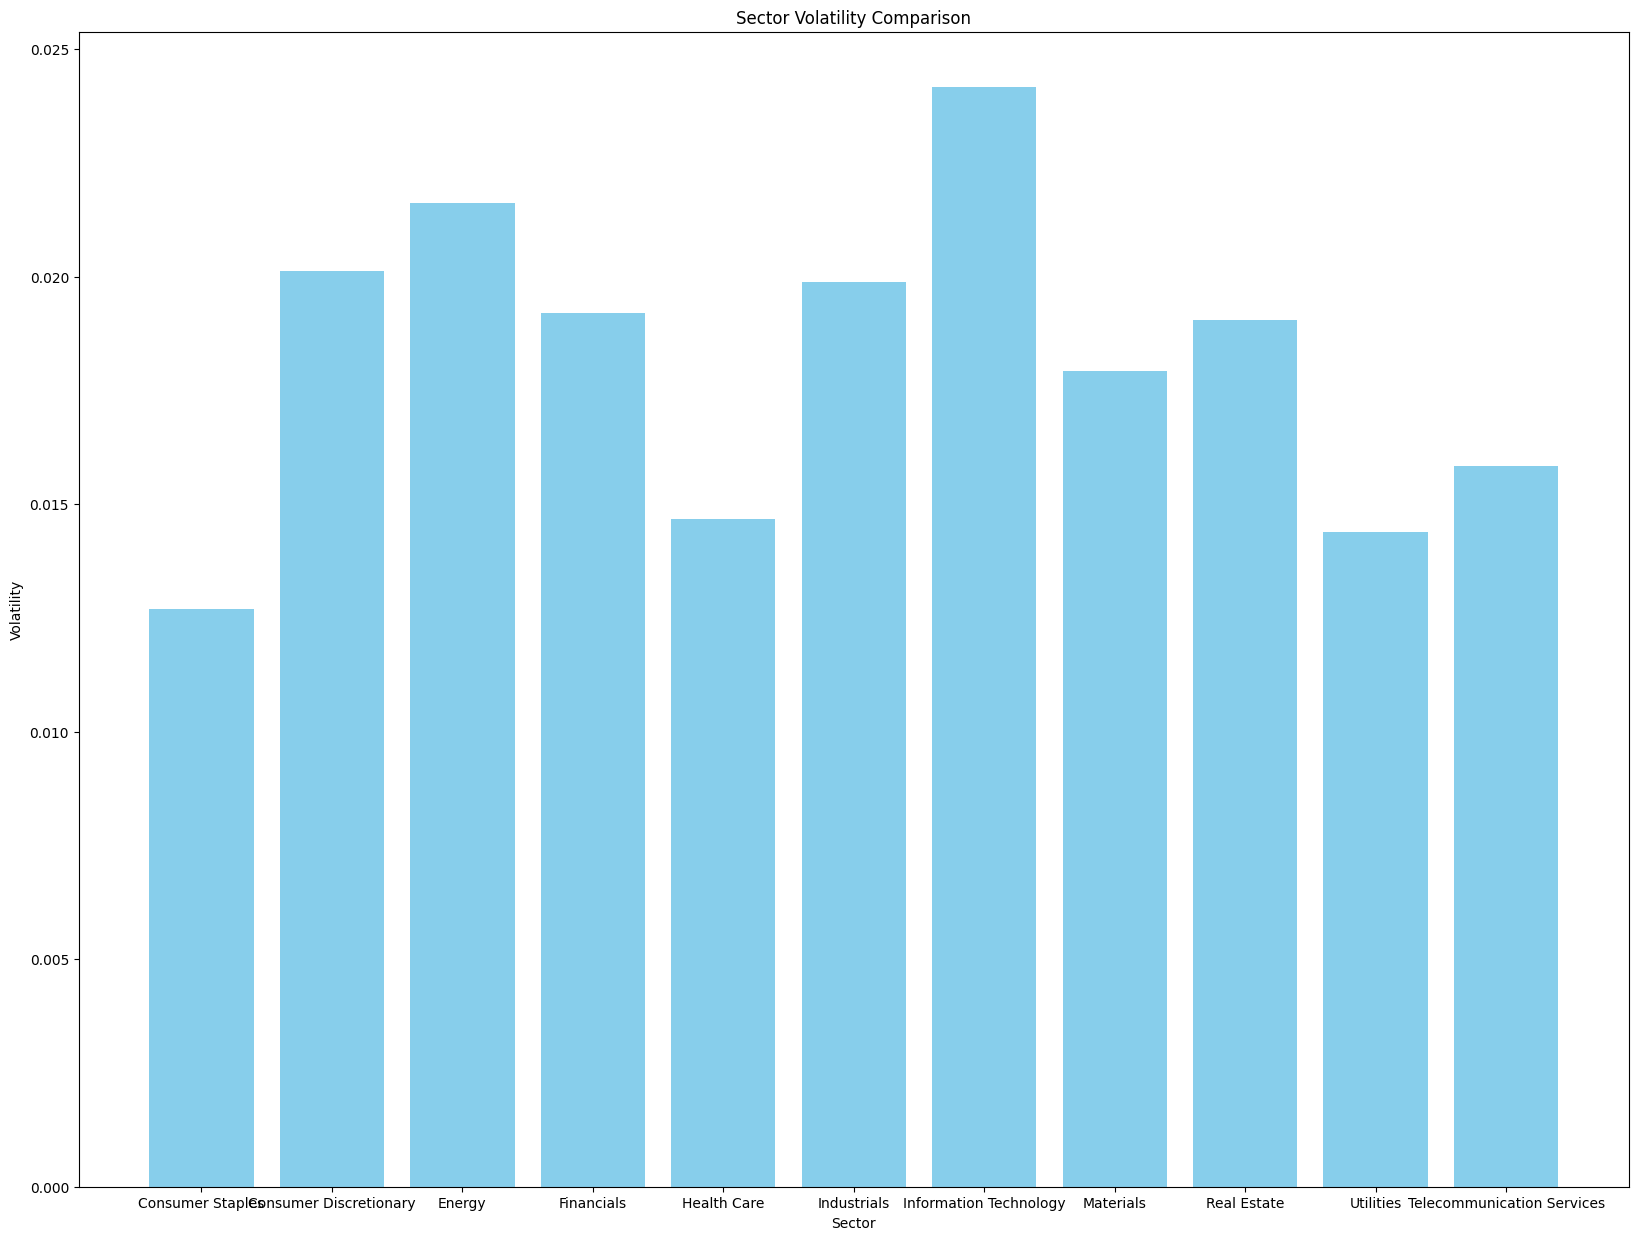

In [16]:
# 변동성 시각화
sectors = list(sector_volatility.keys())
volatilities = list(sector_volatility.values())

plt.figure(figsize=(20, 15))
plt.bar(sectors, volatilities, color='skyblue')
plt.xlabel('Sector')
plt.ylabel('Volatility')
plt.title('Sector Volatility Comparison')
plt.show()


In [38]:
all_stocks_df['1_Close'] = all_stocks_df['Close'].shift(-1)
all_stocks_df['3_Close'] = all_stocks_df['Close'].shift(-3)
all_stocks_df['5_Close'] = all_stocks_df['Close'].shift(-5)


# Create the target variable 'Target'

all_stocks_df['Target1'] = (all_stocks_df['1_Close'] > all_stocks_df['Close']).astype(int)
all_stocks_df['Target3'] = (all_stocks_df['3_Close'] > all_stocks_df['Close']).astype(int)
all_stocks_df['Target5'] = (all_stocks_df['5_Close'] > all_stocks_df['Close']).astype(int)

# Drop rows with NaN values in 'Future_Close' since those cannot be used for prediction

all_stocks_df.dropna(subset=['1_Close'], inplace=True)
all_stocks_df.dropna(subset=['3_Close'], inplace=True)
all_stocks_df.dropna(subset=['5_Close'], inplace=True)

# Drop 'Future_Close' column as it's no longer needed

all_stocks_df.drop(columns=['1_Close'], inplace=True)
all_stocks_df.drop(columns=['3_Close'], inplace=True)
all_stocks_df.drop(columns=['5_Close'], inplace=True)

#타깃 값 5일후 종가 상승할지 하락할지 예측.
#균형잡힌 데이터셋.

all_stocks_df['1_Close'] = all_stocks_df.groupby('Stock')['Close'].shift(-1)
all_stocks_df['3_Close'] = all_stocks_df.groupby('Stock')['Close'].shift(-3)
all_stocks_df['5_Close'] = all_stocks_df.groupby('Stock')['Close'].shift(-5)

# Create the target variable 'Target'

all_stocks_df['Target1'] = (all_stocks_df['1_Close'] > all_stocks_df['Close']).astype(int)
all_stocks_df['Target3'] = (all_stocks_df['3_Close'] > all_stocks_df['Close']).astype(int)
all_stocks_df['Target5'] = (all_stocks_df['5_Close'] > all_stocks_df['Close']).astype(int)
# Drop rows with NaN values in 'Future_Close' since those cannot be used for prediction

all_stocks_df.dropna(subset=['1_Close'], inplace=True)
all_stocks_df.dropna(subset=['3_Close'], inplace=True)
all_stocks_df.dropna(subset=['5_Close'], inplace=True)

# Drop 'Future_Close' column as it's no longer needed

all_stocks_df.drop(columns=['1_Close'], inplace=True)
all_stocks_df.drop(columns=['3_Close'], inplace=True)
all_stocks_df.drop(columns=['5_Close'], inplace=True)

#타깃 값 5일후 종가 상승할지 하락할지 예측.
#균형잡힌 데이터셋.
print((all_stocks_df.Target1==1).sum())
print((all_stocks_df.Target1==0).sum())
print((all_stocks_df.Target3==1).sum())
print((all_stocks_df.Target3==0).sum())
print((all_stocks_df.Target5==1).sum())
print((all_stocks_df.Target5==0).sum())

9827
8784
10379
8232
10697
7914


In [39]:
all_stocks_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock,RSI,MACD,...,BB_Widening,Touch_Upper_Band,Touch_Lower_Band,Momentum_Divergence,Stoch_K,Stoch_D,SNP_Close,Target1,Target3,Target5
49,2015-03-16,30.969999,31.237499,30.717501,31.237499,28.036562,143497200,AAPL,51.021658,0.229702,...,0,0,0,0,33.299867,24.410998,2081.189941,1,1,1
50,2015-03-17,31.475000,31.830000,31.412500,31.760000,28.505508,204092400,AAPL,55.914726,0.240975,...,0,0,0,0,58.549837,36.074651,2074.280029,1,0,0
51,2015-03-18,31.750000,32.290001,31.592501,32.117500,28.826378,261083600,AAPL,58.937439,0.275579,...,0,0,0,0,76.510025,56.119910,2099.500000,0,0,0
52,2015-03-19,32.187500,32.312500,31.850000,31.875000,28.608730,183238000,AAPL,56.126249,0.280206,...,0,0,0,0,67.861291,67.640384,2089.270020,0,0,0
53,2015-03-20,32.062500,32.099998,31.290001,31.475000,28.249716,274780400,AAPL,51.742196,0.248728,...,0,0,0,0,53.778323,66.049880,2108.100098,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19033,2024-05-29,174.190002,178.149994,173.929993,176.190002,176.190002,54782600,TSLA,50.814283,1.590002,...,0,0,0,0,44.119186,50.409480,5266.950195,1,1,0
19034,2024-05-30,178.580002,182.669998,175.380005,178.789993,178.789993,77784800,TSLA,52.836825,1.626978,...,0,0,0,0,57.710353,49.625350,5235.479980,0,0,0
19035,2024-05-31,178.500000,180.320007,173.820007,178.080002,178.080002,67314600,TSLA,52.205518,1.580770,...,0,0,0,0,50.782994,50.870844,5277.509766,0,0,0
19036,2024-06-03,178.130005,182.639999,174.490005,176.289993,176.289993,68568900,TSLA,50.565146,1.383760,...,0,0,0,0,31.456290,46.649879,5283.399902,0,1,0


In [19]:
all_stocks_df.dtypes

Date                   datetime64[ns]
Open                          float64
High                          float64
Low                           float64
Close                         float64
Adj Close                     float64
Volume                          int64
Stock                          object
RSI                           float64
MACD                          float64
SMA_20                        float64
SMA_50                        float64
BB_High                       float64
BB_Low                        float64
BB_Width                      float64
Price_Position                float64
BB_Cross_Above                  int64
BB_Cross_Below                  int64
BB_Tightening                   int64
BB_Widening                     int64
Touch_Upper_Band                int64
Touch_Lower_Band                int64
Momentum_Divergence             int64
Stoch_K                       float64
Stoch_D                       float64
Target1                         int64
Target3     

In [40]:
#주식 Stock 정보 드랍하기
all_stocks_df = all_stocks_df.drop(columns = 'Stock')

In [41]:
correlation_matrix = all_stocks_df.corr()

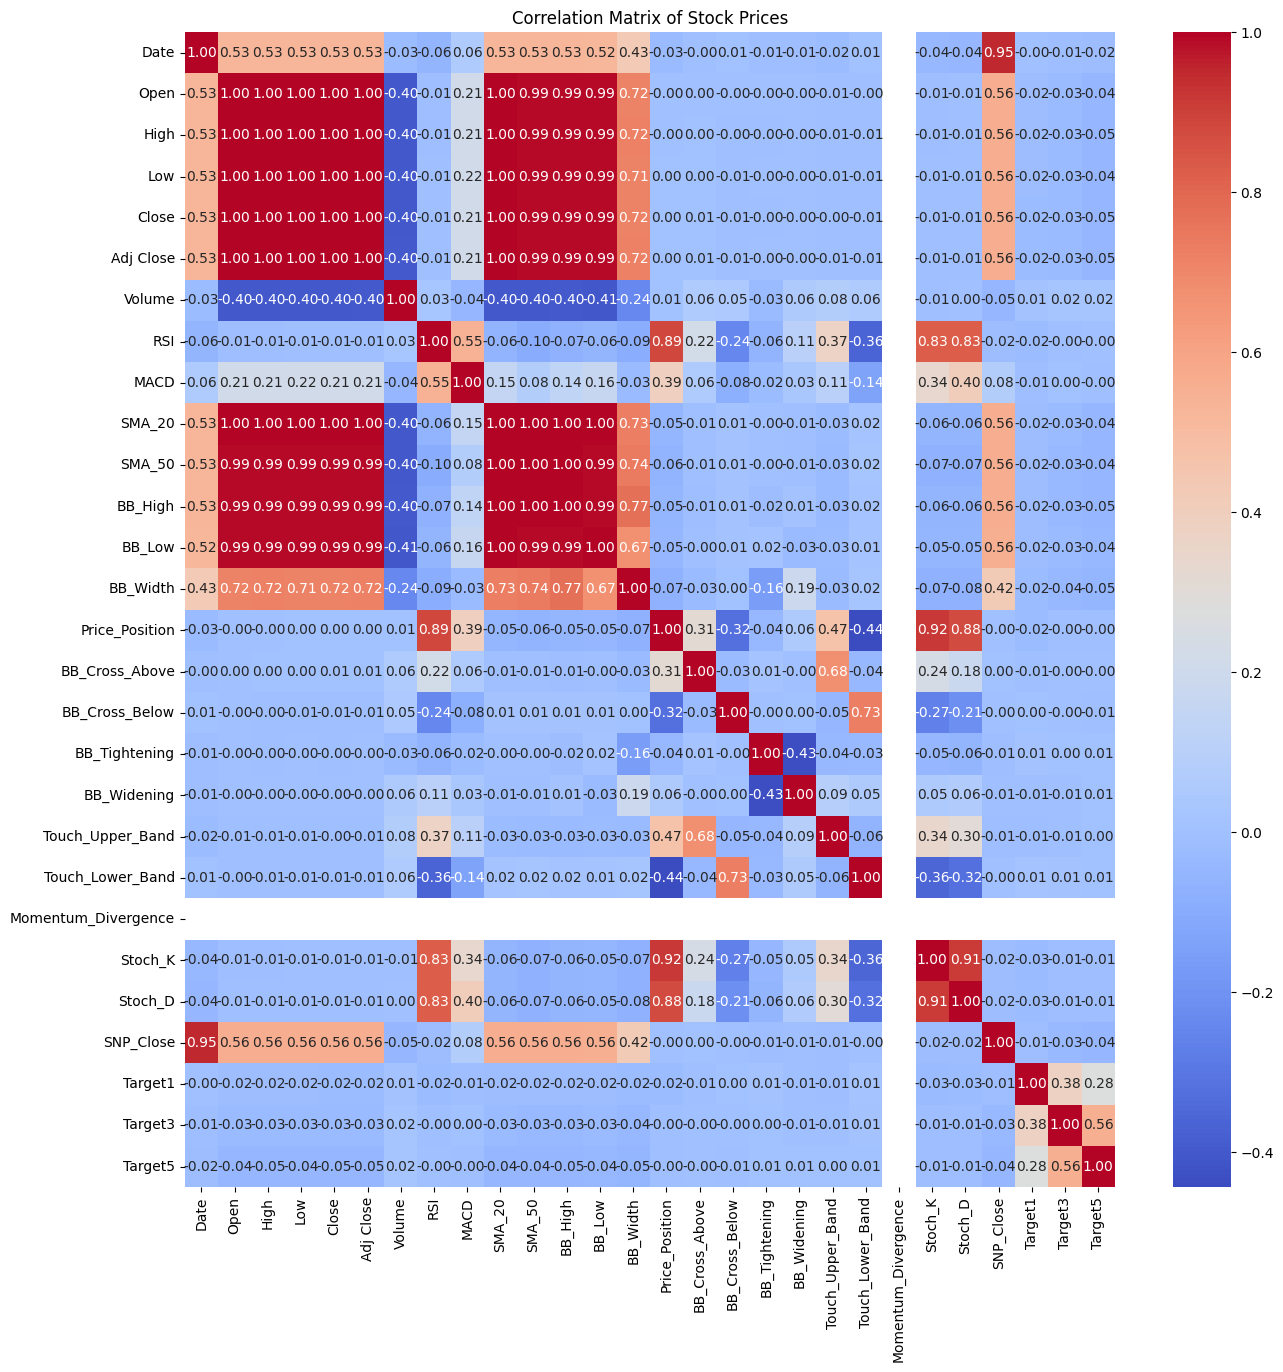

In [42]:
#상관관계 매트릭스 시각화
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Prices')
plt.show()

In [43]:
#날짜 컬럼을 datetime object로 변환. 시계열 데이터를 다룰때 필수적인 과정
all_stocks_df['Date'] = pd.to_datetime(all_stocks_df['Date'])
all_stocks_df.set_index('Date', inplace=True)

In [ ]:
#기술적 분석 없이 시도
features_to_drop = ['Open','High','Low','Adj Close']
final_stocks_df = all_stocks_df.drop(columns=features_to_drop)

In [44]:
#데이터 전처리
#상관성이 높은 피처들 제거.
#종가만 남기고
features_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'SMA_50', 'BB_Low', 'Stoch_D']

# Drop the selected features
final_stocks_df = all_stocks_df.drop(columns=features_to_drop)

# Display the remaining features
print(final_stocks_df.columns)
final_stocks_df

Index(['Close', 'Volume', 'RSI', 'MACD', 'SMA_20', 'BB_High', 'BB_Width',
       'Price_Position', 'BB_Cross_Above', 'BB_Cross_Below', 'BB_Tightening',
       'BB_Widening', 'Touch_Upper_Band', 'Touch_Lower_Band',
       'Momentum_Divergence', 'Stoch_K', 'SNP_Close', 'Target1', 'Target3',
       'Target5'],
      dtype='object')


,Close,Volume,RSI,MACD,SMA_20,BB_High,BB_Width,Price_Position,BB_Cross_Above,BB_Cross_Below,BB_Tightening,BB_Widening,Touch_Upper_Band,Touch_Lower_Band,Momentum_Divergence,Stoch_K,SNP_Close,Target1,Target3,Target5
Date,,,,,,,,,,,,,,,,,,,,
2015-03-16,31.237499,143497200,51.021658,0.229702,31.927750,33.277186,2.698872,0.244245,0,0,1,0,0,0,0,33.299867,2081.189941,1,1,1
2015-03-17,31.760000,204092400,55.914726,0.240975,31.917875,33.269185,2.702620,0.441585,0,0,1,0,0,0,0,58.549837,2074.280029,1,0,0
2015-03-18,32.117500,261083600,58.937439,0.275579,31.914750,33.263908,2.698316,0.575140,0,0,1,0,0,0,0,76.510025,2099.500000,0,0,0
2015-03-19,31.875000,183238000,56.126249,0.280206,31.902875,33.249039,2.692329,0.489647,0,0,1,0,0,0,0,67.861291,2089.270020,0,0,0
2015-03-20,31.475000,274780400,51.742196,0.248728,31.857875,33.198059,2.680368,0.357156,0,0,1,0,0,0,0,53.778323,2108.100098,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-29,176.190002,54782600,50.814283,1.590002,177.111501,185.622575,17.022147,0.445865,0,0,1,0,0,0,0,44.119186,5266.950195,1,1,0
2024-05-30,178.789993,77784800,52.836825,1.626978,177.051501,185.497226,16.891451,0.602921,0,0,1,0,0,0,0,57.710353,5235.479980,0,0,0
2024-05-31,178.080002,67314600,52.205518,1.580770,176.955001,185.306891,16.703779,0.567350,0,0,1,0,0,0,0,50.782994,5277.509766,0,0,0


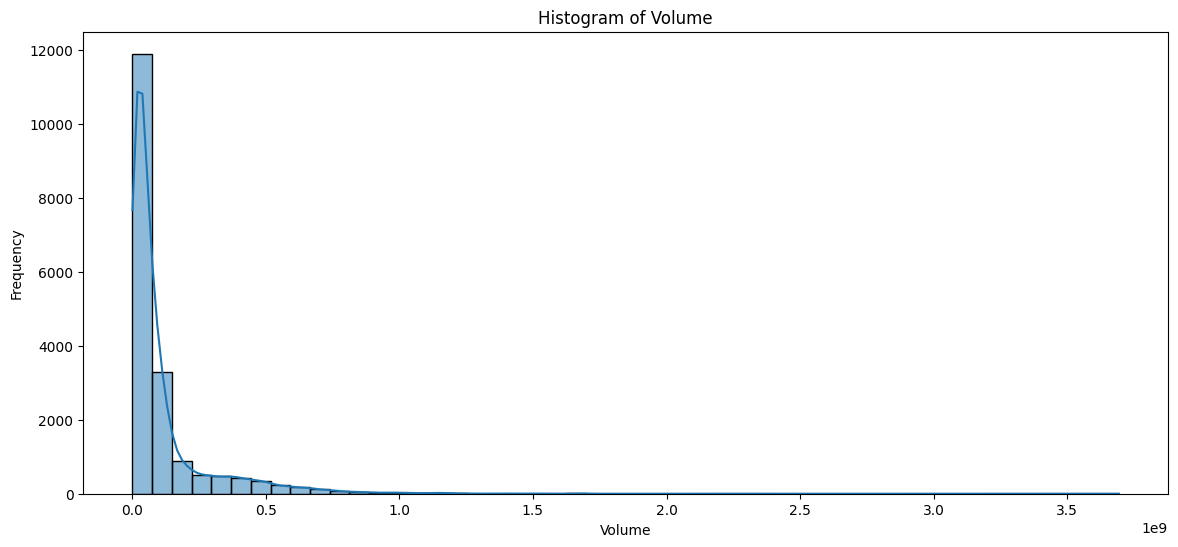

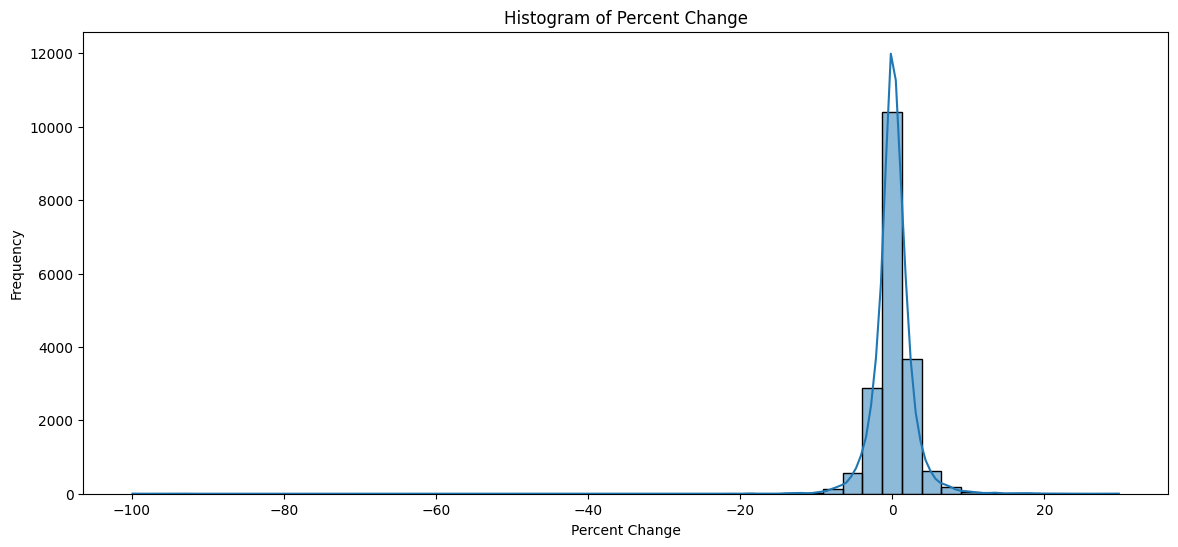

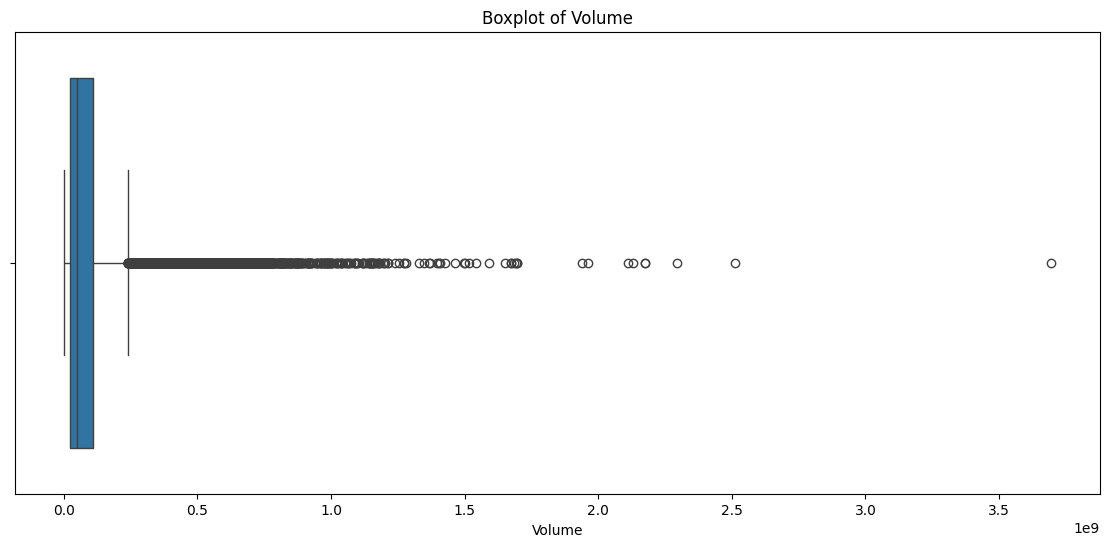

In [30]:
# Calculate percent change
final_stocks_df['Percent Change'] = final_stocks_df['Close'].pct_change() * 100
# Plot histogram for 'Volume'
plt.figure(figsize=(14, 6))
sns.histplot(final_stocks_df['Volume'], bins=50, kde=True)
plt.title('Histogram of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'Percent Change'
plt.figure(figsize=(14, 6))
sns.histplot(final_stocks_df['Percent Change'], bins=50, kde=True)
plt.title('Histogram of Percent Change')
plt.xlabel('Percent Change')
plt.ylabel('Frequency')
plt.show()

# Plot boxplot for 'Volume'
plt.figure(figsize=(14, 6))
sns.boxplot(x=final_stocks_df['Volume'])
plt.title('Boxplot of Volume')
plt.show()



In [31]:
final_stocks_df.drop(columns=['Percent Change'], inplace=True)

In [45]:
final_stocks_df

,Close,Volume,RSI,MACD,SMA_20,BB_High,BB_Width,Price_Position,BB_Cross_Above,BB_Cross_Below,BB_Tightening,BB_Widening,Touch_Upper_Band,Touch_Lower_Band,Momentum_Divergence,Stoch_K,SNP_Close,Target1,Target3,Target5
Date,,,,,,,,,,,,,,,,,,,,
2015-03-16,31.237499,143497200,51.021658,0.229702,31.927750,33.277186,2.698872,0.244245,0,0,1,0,0,0,0,33.299867,2081.189941,1,1,1
2015-03-17,31.760000,204092400,55.914726,0.240975,31.917875,33.269185,2.702620,0.441585,0,0,1,0,0,0,0,58.549837,2074.280029,1,0,0
2015-03-18,32.117500,261083600,58.937439,0.275579,31.914750,33.263908,2.698316,0.575140,0,0,1,0,0,0,0,76.510025,2099.500000,0,0,0
2015-03-19,31.875000,183238000,56.126249,0.280206,31.902875,33.249039,2.692329,0.489647,0,0,1,0,0,0,0,67.861291,2089.270020,0,0,0
2015-03-20,31.475000,274780400,51.742196,0.248728,31.857875,33.198059,2.680368,0.357156,0,0,1,0,0,0,0,53.778323,2108.100098,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-29,176.190002,54782600,50.814283,1.590002,177.111501,185.622575,17.022147,0.445865,0,0,1,0,0,0,0,44.119186,5266.950195,1,1,0
2024-05-30,178.789993,77784800,52.836825,1.626978,177.051501,185.497226,16.891451,0.602921,0,0,1,0,0,0,0,57.710353,5235.479980,0,0,0
2024-05-31,178.080002,67314600,52.205518,1.580770,176.955001,185.306891,16.703779,0.567350,0,0,1,0,0,0,0,50.782994,5277.509766,0,0,0


In [46]:
final_stocks_df.columns

Index(['Close', 'Volume', 'RSI', 'MACD', 'SMA_20', 'BB_High', 'BB_Width',
       'Price_Position', 'BB_Cross_Above', 'BB_Cross_Below', 'BB_Tightening',
       'BB_Widening', 'Touch_Upper_Band', 'Touch_Lower_Band',
       'Momentum_Divergence', 'Stoch_K', 'SNP_Close', 'Target1', 'Target3',
       'Target5'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Define the features to scale(기술적 분석)
# features_to_scale = ['Close', 'Volume', 'RSI', 'MACD', 'SMA_20', 'BB_High', 'Stoch_K','SNP_Close']
# Define the featuers to scale
features_to_scale = ['Close','Volume','SNP_Close']
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the features and update the DataFrame
final_stocks_df[features_to_scale] = scaler.fit_transform(final_stocks_df[features_to_scale])

# Display the first few rows of the scaled DataFrame
print(final_stocks_df[features_to_scale])

               Close    Volume  SNP_Close
Date                                     
2015-08-10 -0.861953  0.603034  -1.281610
2015-08-11 -0.874194  1.548491  -1.303486
2015-08-12 -0.870756  1.641277  -1.301332
2015-08-13 -0.870932  0.459059  -1.304226
2015-08-14 -0.869341  0.333249  -1.295360
...              ...       ...        ...
2024-05-09  0.254447 -0.260128   2.101352
2024-05-10  0.226938 -0.222669   2.110707
2024-05-13  0.253818 -0.254133   2.109336
2024-05-14  0.298305 -0.145359   2.136815
2024-05-15  0.270324 -0.183197   2.203682

[17691 rows x 3 columns]


In [47]:
from sklearn.preprocessing import MinMaxScaler

# Define the features to scale(기술적 분석)
# features_to_scale = ['Close', 'Volume', 'RSI', 'MACD', 'SMA_20', 'BB_High', 'Stoch_K','SNP_Close']
# Define the featuers to scale
features_to_scale = ['Close','Volume','SNP_Close']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features and update the DataFrame
final_stocks_df[features_to_scale] = scaler.fit_transform(final_stocks_df[features_to_scale])

# Display the first few rows of the scaled DataFrame
print(final_stocks_df[features_to_scale])

               Close    Volume  SNP_Close
Date                                     
2015-03-16  0.044494  0.038559   0.071092
2015-03-17  0.045250  0.054973   0.069144
2015-03-18  0.045767  0.070410   0.076255
2015-03-19  0.045417  0.049324   0.073371
2015-03-20  0.044838  0.074120   0.078681
...              ...       ...        ...
2024-05-29  0.254203  0.014529   0.969441
2024-05-30  0.257965  0.020760   0.960567
2024-05-31  0.256938  0.017924   0.972419
2024-06-03  0.254348  0.018264   0.974080
2024-06-04  0.252149  0.015958   0.976319

[18611 rows x 3 columns]


In [50]:
# Drop rows with NaN values in any of the columns
final_stocks_df.dropna(inplace=True)

In [59]:
# Split the data into train, validation, and test sets based on date
train_df = final_stocks_df[final_stocks_df.index <= '2022-06-06']
valid_df = final_stocks_df[(final_stocks_df.index >= '2022-06-07') & (final_stocks_df.index < '2023-06-06')]
test_df = final_stocks_df[(final_stocks_df.index >= '2023-06-07')&(final_stocks_df.index <= '2024-05-31')]

#타깃값 바꿔가면서 모델링 시도
# Separate features and target
X_train = train_df.drop(columns=['Target1','Target3','Target5'])
y_train = train_df['Target5']
X_valid = valid_df.drop(columns=['Target1','Target3','Target5'])
y_valid = valid_df['Target5']
X_test = test_df.drop(columns=['Target1','Target3','Target5'])
y_test = test_df['Target5']

In [60]:
X_train

,Close,Volume,RSI,MACD,SMA_20,BB_High,BB_Width,Price_Position,BB_Cross_Above,BB_Cross_Below,BB_Tightening,BB_Widening,Touch_Upper_Band,Touch_Lower_Band,Momentum_Divergence,Stoch_K,SNP_Close
Date,,,,,,,,,,,,,,,,,
2015-03-16,0.044494,0.038559,51.021658,0.229702,31.927750,33.277186,2.698872,0.244245,0,0,1,0,0,0,0,33.299867,0.071092
2015-03-17,0.045250,0.054973,55.914726,0.240975,31.917875,33.269185,2.702620,0.441585,0,0,1,0,0,0,0,58.549837,0.069144
2015-03-18,0.045767,0.070410,58.937439,0.275579,31.914750,33.263908,2.698316,0.575140,0,0,1,0,0,0,0,76.510025,0.076255
2015-03-19,0.045417,0.049324,56.126249,0.280206,31.902875,33.249039,2.692329,0.489647,0,0,1,0,0,0,0,67.861291,0.073371
2015-03-20,0.044838,0.074120,51.742196,0.248728,31.857875,33.198059,2.680368,0.357156,0,0,1,0,0,0,0,53.778323,0.078681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.364971,0.027296,46.683386,-18.286504,252.935500,308.843988,111.816977,0.498371,0,0,0,0,0,0,0,72.774820,0.649440
2022-06-01,0.356344,0.020614,44.818871,-16.615840,250.120832,301.097904,101.954144,0.467330,0,0,0,0,0,0,0,71.831123,0.640721
2022-06-02,0.373044,0.025009,49.060077,-14.196724,247.160499,288.001992,81.682987,0.636783,0,0,1,0,0,0,0,89.753604,0.662036


In [61]:
def count_nan_values(df, name):
    nan_counts = df.isnull().sum()
    print(f"NaN values in each column of {name}:\n{nan_counts}")

count_nan_values(X_train, "X_train")
count_nan_values(y_train.to_frame(), "y_train")
count_nan_values(X_valid, "X_valid")
count_nan_values(y_valid.to_frame(), "y_valid")
count_nan_values(X_test, "X_test")
count_nan_values(y_test.to_frame(), "y_test")

# Display rows with NaN values for detailed inspection
def display_rows_with_nan(df, name):
    rows_with_nan = df[df.isnull().any(axis=1)]
    if not rows_with_nan.empty:
        print(f"Rows with NaN values in {name}:\n{rows_with_nan}")
    else:
        print(f"No rows with NaN values in {name}.")

display_rows_with_nan(X_train, "X_train")
display_rows_with_nan(y_train.to_frame(), "y_train")
display_rows_with_nan(X_valid, "X_valid")
display_rows_with_nan(y_valid.to_frame(), "y_valid")
display_rows_with_nan(X_test, "X_test")
display_rows_with_nan(y_test.to_frame(), "y_test")

NaN values in each column of X_train:
Close                  0
Volume                 0
RSI                    0
MACD                   0
SMA_20                 0
BB_High                0
BB_Width               0
Price_Position         0
BB_Cross_Above         0
BB_Cross_Below         0
BB_Tightening          0
BB_Widening            0
Touch_Upper_Band       0
Touch_Lower_Band       0
Momentum_Divergence    0
Stoch_K                0
SNP_Close              0
dtype: int64
NaN values in each column of y_train:
Target5    0
dtype: int64
NaN values in each column of X_valid:
Close                  0
Volume                 0
RSI                    0
MACD                   0
SMA_20                 0
BB_High                0
BB_Width               0
Price_Position         0
BB_Cross_Above         0
BB_Cross_Below         0
BB_Tightening          0
BB_Widening            0
Touch_Upper_Band       0
Touch_Lower_Band       0
Momentum_Divergence    0
Stoch_K                0
SNP_Close             

In [54]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# RandomForest parameters
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# XGBoost parameters
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}


# RandomForestClassifier with RandomizedSearchCV
rf = RandomForestClassifier(random_state=1)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=1)
rf_random.fit(X_train, y_train)
rf_best = rf_random.best_estimator_

# XGBoostClassifier with RandomizedSearchCV
xgb = XGBClassifier(random_state=1, use_label_encoder=False)
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=1)
xgb_random.fit(X_train, y_train)
xgb_best = xgb_random.best_estimator_

# Evaluate on the validation set
rf_valid_pred = rf_best.predict(X_valid)
xgb_valid_pred = xgb_best.predict(X_valid)

print("Validation Accuracy for RandomForest:", accuracy_score(y_valid, rf_valid_pred))
print("Validation Accuracy for XGBoost:", accuracy_score(y_valid, xgb_valid_pred))

Validation Accuracy for RandomForest: 0.5065
Validation Accuracy for XGBoost: 0.508


In [55]:
print(rf_random.best_params_)
print(rf_random.best_params_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}


In [62]:
# Assuming you have already found the best parameters using RandomizedSearchCV
best_rf_params = rf_random.best_params_
best_xgb_params = xgb_random.best_params_

# Print the best parameters (for confirmation, you can remove these print statements later)
print("Best parameters for RandomForestClassifier:", best_rf_params)
print("Best parameters for XGBoostClassifier:", best_xgb_params)

# Create the RandomForestClassifier with the best parameters
rf_best = RandomForestClassifier(**best_rf_params, random_state=1)
# Fit the model on the training data
rf_best.fit(X_train, y_train)

# Create the XGBClassifier with the best parameters
xgb_best = XGBClassifier(**best_xgb_params, random_state=1, use_label_encoder=False)
# Fit the model on the training data
xgb_best.fit(X_train, y_train)

# Evaluate on the validation set
rf_valid_pred = rf_best.predict(X_valid)
xgb_valid_pred = xgb_best.predict(X_valid)

print("Validation Accuracy for RandomForest:", accuracy_score(y_valid, rf_valid_pred))
print("Validation Accuracy for XGBoost:", accuracy_score(y_valid, xgb_valid_pred))


Best parameters for RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Best parameters for XGBoostClassifier: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05}
Validation Accuracy for RandomForest: 0.5585
Validation Accuracy for XGBoost: 0.5385


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Define a function to evaluate models
def evaluate_model(model, X_valid, y_valid, X_test, y_test):
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)

    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1-Score': f1_score,
        'ROC-AUC': roc_auc_score
    }

    print(f"\nEvaluation for {model.__class__.__name__} on Validation Set:")
    for name, metric in metrics.items():
        if name == 'ROC-AUC':
            print(f"{name}: {metric(y_valid, model.predict_proba(X_valid)[:, 1]):.4f}")
        else:
            print(f"{name}: {metric(y_valid, valid_pred):.4f}")

    print(f"\nEvaluation for {model.__class__.__name__} on Test Set:")
    for name, metric in metrics.items():
        if name == 'ROC-AUC':
            print(f"{name}: {metric(y_test, model.predict_proba(X_test)[:, 1]):.4f}")
        else:
            print(f"{name}: {metric(y_test, test_pred):.4f}")

# Evaluate models
evaluate_model(rf_best, X_valid, y_valid, X_test, y_test)
evaluate_model(xgb_best, X_valid, y_valid, X_test, y_test)



Evaluation for RandomForestClassifier on Validation Set:
Accuracy: 0.5065
Precision: 0.5051
Recall: 0.8806
F1-Score: 0.6420
ROC-AUC: 0.4977

Evaluation for RandomForestClassifier on Test Set:
Accuracy: 0.5091
Precision: 0.5577
Recall: 0.4088
F1-Score: 0.4718
ROC-AUC: 0.5096

Evaluation for XGBClassifier on Validation Set:
Accuracy: 0.5080
Precision: 0.5075
Recall: 0.7035
F1-Score: 0.5897
ROC-AUC: 0.5078

Evaluation for XGBClassifier on Test Set:
Accuracy: 0.5202
Precision: 0.5763
Recall: 0.3976
F1-Score: 0.4705
ROC-AUC: 0.5317


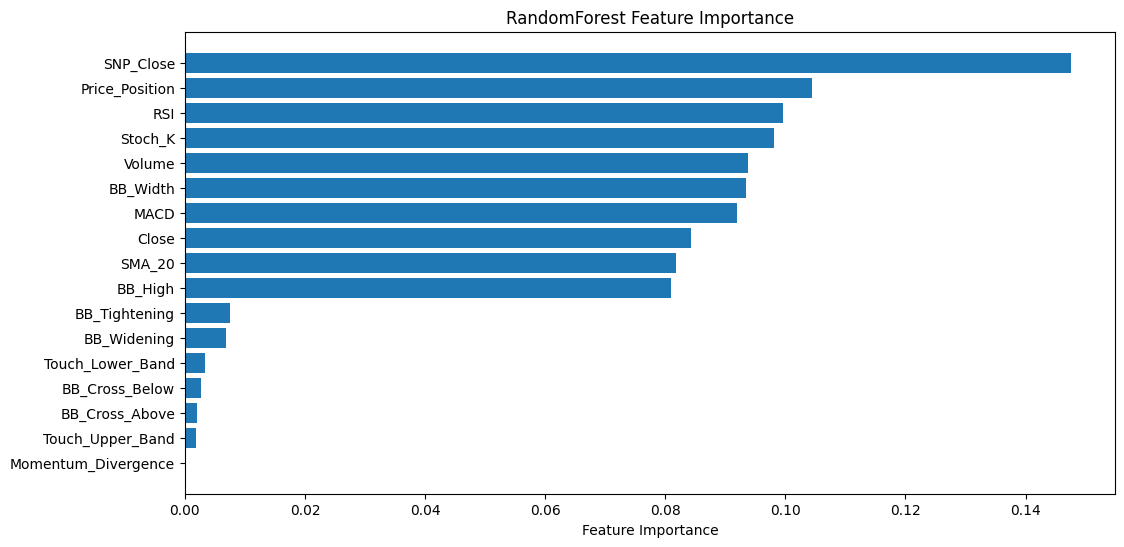

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rf_best is your trained RandomForestClassifier

# Get feature importances
rf_feature_importances = rf_best.feature_importances_

# Create a DataFrame for visualization
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(rf_feature_importance_df['Feature'], rf_feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('RandomForest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


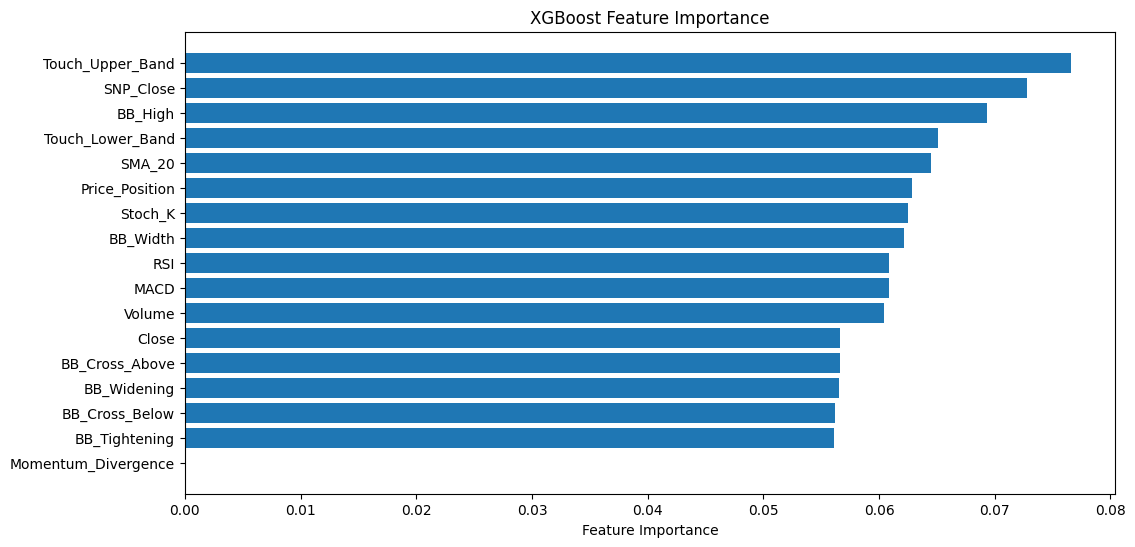

In [ ]:
# Assuming xgb_best is your trained XGBoostClassifier

# Get feature importances
xgb_feature_importances = xgb_best.feature_importances_

# Create a DataFrame for visualization
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(xgb_feature_importance_df['Feature'], xgb_feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()


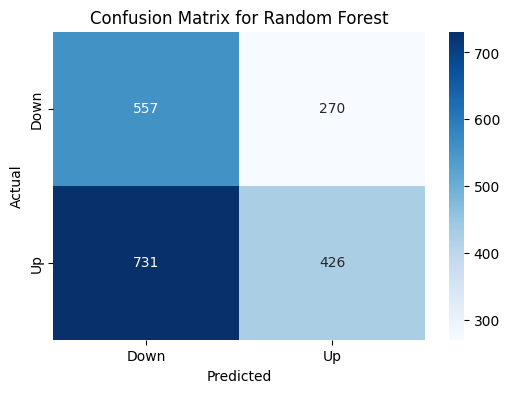

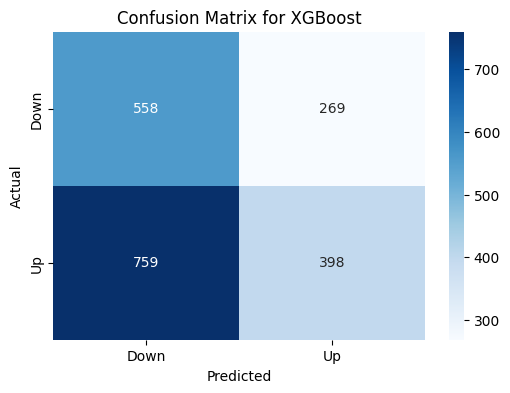

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()


# Function to evaluate and plot
def evaluate_and_plot(model, X_test, y_test, model_name):
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]

    # Confusion Matrix
    plot_confusion_matrix(y_test, test_pred, f'Confusion Matrix for {model_name}')

# Evaluate and plot for each model
evaluate_and_plot(rf_best, X_test, y_test, 'Random Forest')
evaluate_and_plot(xgb_best, X_test, y_test, 'XGBoost')



In [65]:
# Apply PCA to reduce dimensionality
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=10)
# PCA 적용 (10차원으로 축소)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)
# RandomForest parameters
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# XGBoost parameters
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}

# RandomForestClassifier with RandomizedSearchCV
rf = RandomForestClassifier(random_state=1)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=1)
rf_random.fit(X_train_pca, y_train)
rf_best = rf_random.best_estimator_

# XGBoostClassifier with RandomizedSearchCV
xgb = XGBClassifier(random_state=1, use_label_encoder=False)
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=1)
xgb_random.fit(X_train_pca, y_train)
xgb_best = xgb_random.best_estimator_

# Evaluate on the validation set
rf_valid_pred = rf_best.predict(X_valid_pca)
xgb_valid_pred = xgb_best.predict(X_valid_pca)

print("Validation Accuracy for RandomForest PCA:", accuracy_score(y_valid, rf_valid_pred))
print("Validation Accuracy for XGBoost PCA:", accuracy_score(y_valid, xgb_valid_pred))

Validation Accuracy for RandomForest PCA: 0.557
Validation Accuracy for XGBoost PCA: 0.557


,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,SMA_20,SMA_50,...,BB_Widening,Touch_Upper_Band,Touch_Lower_Band,Momentum_Divergence,Stoch_K,Stoch_D,SNP_Close,Target1,Target3,Target5
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-10,29.132500,29.997499,29.132500,-0.861953,27.060640,0.603034,-0.903872,-0.273368,-0.854005,31.33990,...,1,0,0,0,-0.260977,27.259620,-1.281610,0,0,0
2015-08-11,29.452499,29.545000,28.332500,-0.874194,25.652458,1.548491,-1.750732,-0.286382,-0.855205,31.25465,...,1,0,0,0,-1.643621,25.511088,-1.303486,1,1,1
2015-08-12,28.132500,28.855000,27.407499,-0.870756,26.048012,1.641277,-1.383063,-0.288333,-0.856352,31.18105,...,1,0,0,0,-0.793621,31.643285,-1.301332,0,1,0
2015-08-13,29.010000,29.100000,28.635000,-0.870932,26.027678,0.459059,-1.394454,-0.288564,-0.857675,31.10620,...,1,0,0,0,-0.666127,27.583805,-1.304226,1,1,0
2015-08-14,28.580000,29.077499,28.502501,-0.869341,26.210762,0.333249,-1.217126,-0.284036,-0.859028,31.03920,...,1,0,0,0,-0.477424,39.268764,-1.295360,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-09,175.009995,175.619995,171.369995,0.254447,171.970001,-0.260128,-0.416266,0.262037,0.232186,172.49560,...,1,0,0,0,-0.115098,59.985575,2.101352,0,1,1
2024-05-10,173.050003,173.059998,167.750000,0.226938,168.470001,-0.222669,-0.608739,0.136106,0.231164,171.82740,...,1,0,0,0,-0.376266,54.128084,2.110707,1,1,1
2024-05-13,170.000000,175.399994,169.000000,0.253818,171.889999,-0.254133,-0.402727,0.086064,0.235288,171.21240,...,1,0,0,0,-0.795458,45.785082,2.109336,1,1,1


In [66]:
evaluate_model(rf_best, X_valid_pca, y_valid, X_test_pca, y_test)
evaluate_model(xgb_best, X_valid_pca, y_valid, X_test_pca, y_test)


Evaluation for RandomForestClassifier on Validation Set:
Accuracy: 0.5570
Precision: 0.5824
Recall: 0.7511
F1-Score: 0.6561
ROC-AUC: 0.5275

Evaluation for RandomForestClassifier on Test Set:
Accuracy: 0.4924
Precision: 0.6050
Recall: 0.3734
F1-Score: 0.4618
ROC-AUC: 0.5197

Evaluation for XGBClassifier on Validation Set:
Accuracy: 0.5570
Precision: 0.5748
Recall: 0.8160
F1-Score: 0.6745
ROC-AUC: 0.5239

Evaluation for XGBClassifier on Test Set:
Accuracy: 0.5393
Precision: 0.6118
Recall: 0.5748
F1-Score: 0.5927
ROC-AUC: 0.5185


In [67]:
#pca 적용하여 진행
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
# Evaluate on the test set
rf_test_pred = rf_best.predict(X_test_pca)
xgb_test_pred = xgb_best.predict(X_test_pca)

rf_test_pred = rf_best.predict(X_test_pca)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
rf_test_precision = precision_score(y_test, rf_test_pred)
rf_test_recall = recall_score(y_test, rf_test_pred)
rf_test_f1 = f1_score(y_test, rf_test_pred)
rf_test_roc_auc = roc_auc_score(y_test, rf_test_pred)


print("RandomForest Test Accuracy:", rf_test_accuracy)
print("RandomForest test Precision:", rf_test_precision)
print("RandomForest test Recall:", rf_test_recall)
print("RandomForest test F1-Score:", rf_test_f1)
print("RandomForest test ROC-AUC:", rf_test_roc_auc)



# Evaluate XGBoost on the validation set
xgb_test_pred = xgb_best.predict(X_test_pca)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)
xgb_test_precision = precision_score(y_test, xgb_test_pred)
xgb_test_recall = recall_score(y_test, xgb_test_pred)
xgb_test_f1 = f1_score(y_test, xgb_test_pred)
xgb_test_roc_auc = roc_auc_score(y_test, xgb_test_pred)


print("XGBoost test Accuracy:", xgb_test_accuracy)
print("XGBoost test Precision:", xgb_test_precision)
print("XGBoost test Recall:", xgb_test_recall)
print("XGBoost test F1-Score:", xgb_test_f1)
print("XGBoost test ROC-AUC:", xgb_test_roc_auc)

RandomForest Test Accuracy: 0.49243951612903225
RandomForest test Precision: 0.6050420168067226
RandomForest test Recall: 0.37337942955920483
RandomForest test F1-Score: 0.46178514163548895
RandomForest test ROC-AUC: 0.5161939469440522
XGBoost test Accuracy: 0.5393145161290323
XGBoost test Precision: 0.6117755289788408
XGBoost test Recall: 0.57476231633535
XGBoost test F1-Score: 0.5926916221033868
XGBoost test ROC-AUC: 0.5322421013357523


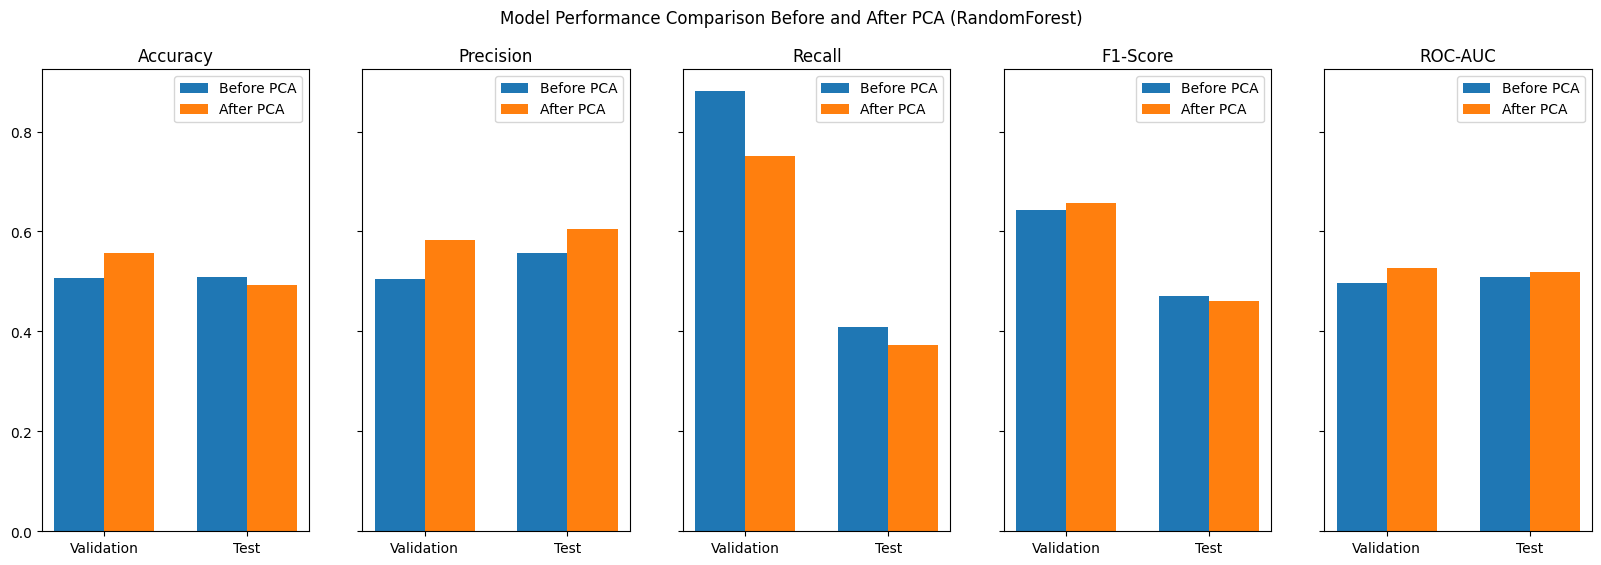

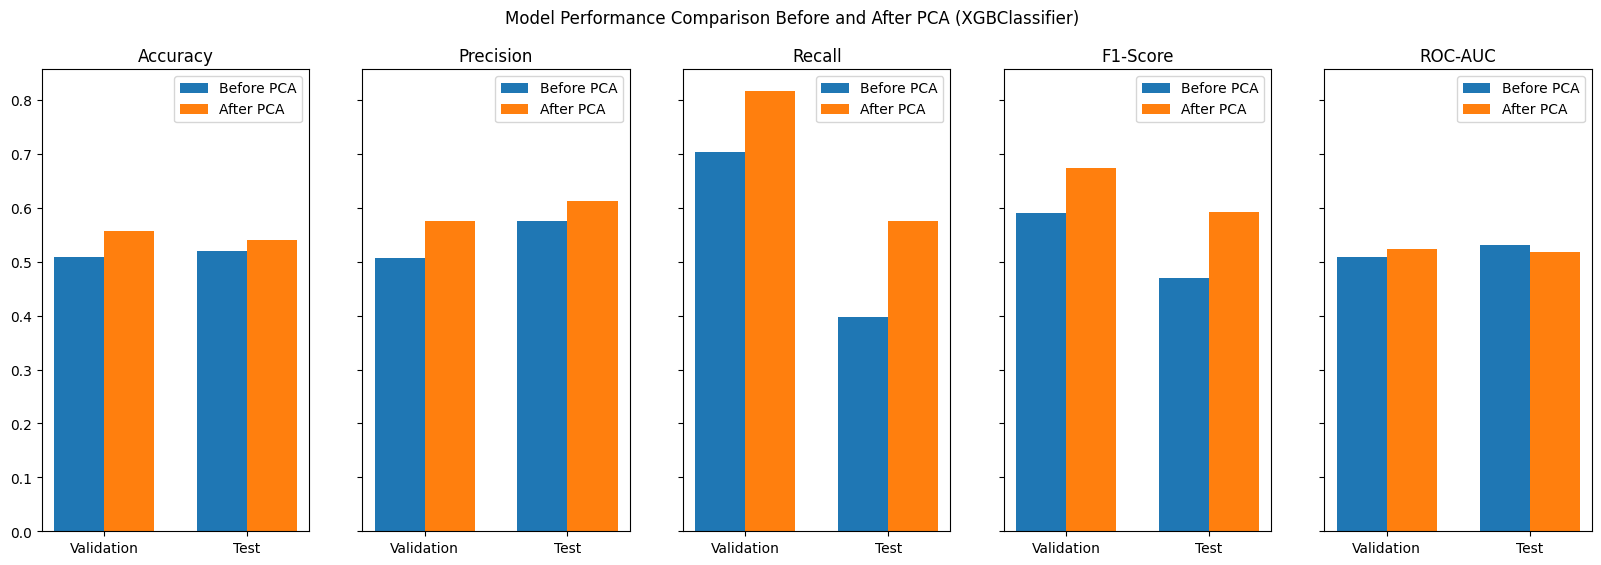

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics for both models before and after PCA
metrics_before_pca = {
    "RandomForest": {
        "Accuracy": [0.5065, 0.5091],
        "Precision": [0.5051, 0.5577],
        "Recall": [0.8806, 0.4088],
        "F1-Score": [0.6420, 0.4718],
        "ROC-AUC": [0.4977, 0.5096]
    },
    "XGBClassifier": {
        "Accuracy": [0.5080, 0.5202],
        "Precision": [0.5075, 0.5763],
        "Recall": [0.7035, 0.3976],
        "F1-Score": [0.5897, 0.4705],
        "ROC-AUC": [0.5078, 0.5317]
    }
}

metrics_after_pca = {
    "RandomForest": {
        "Accuracy": [0.5570, 0.4924],
        "Precision": [0.5824, 0.6050],
        "Recall": [0.7511, 0.3734],
        "F1-Score": [0.6561, 0.4618],
        "ROC-AUC": [0.5275, 0.5197]
    },
    "XGBClassifier": {
        "Accuracy": [0.5570, 0.5393],
        "Precision": [0.5748, 0.6118],
        "Recall": [0.8160, 0.5748],
        "F1-Score": [0.6745, 0.5927],
        "ROC-AUC": [0.5239, 0.5185]
    }
}

def plot_metrics(metrics_before, metrics_after, model_name):
    labels = ["Validation", "Test"]
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, axs = plt.subplots(1, len(metrics), figsize=(20, 6), sharey=True)
    fig.suptitle(f'Model Performance Comparison Before and After PCA ({model_name})')

    for i, metric in enumerate(metrics):
        before_values = metrics_before[model_name][metric]
        after_values = metrics_after[model_name][metric]

        rects1 = axs[i].bar(x - width/2, before_values, width, label='Before PCA')
        rects2 = axs[i].bar(x + width/2, after_values, width, label='After PCA')

        axs[i].set_title(metric)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(labels)
        axs[i].legend()

    plt.show()

# Plot the metrics for RandomForestClassifier
plot_metrics(metrics_before_pca, metrics_after_pca, "RandomForest")

# Plot the metrics for XGBClassifier
plot_metrics(metrics_before_pca, metrics_after_pca, "XGBClassifier")


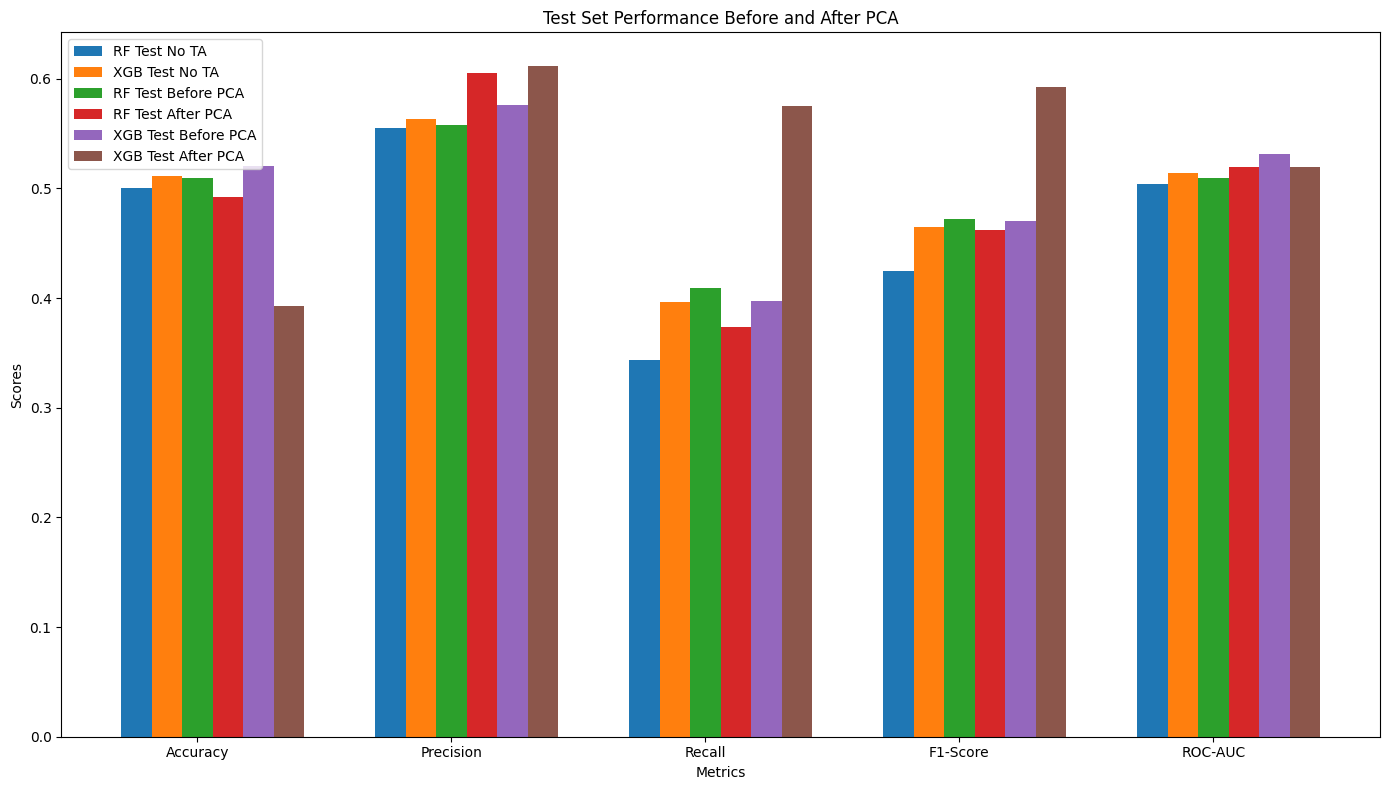

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 성능 결과
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
rf_test_NoTA = [0.5008, 0.5554, 0.3440, 0.4248, 0.5043]
xgb_test_NoTA = [0.5117, 0.5632, 0.3961, 0.4651, 0.5145]
rf_test_before = [0.5091, 0.5577, 0.4088, 0.4718, 0.5096]
rf_test_after = [0.4924, 0.6050, 0.3734, 0.4618, 0.5197]
xgb_test_before = [0.5202, 0.5763, 0.3976, 0.4705, 0.5317]
xgb_test_after = [0.393, 0.6118, 0.5748, 0.5927, 0.5198]

# 막대 그래프 생성
x = np.arange(len(metrics))
width = 0.12  # Reduce the width to make room for more bars and spacing

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - 2*width, rf_test_NoTA, width, label='RF Test No TA')
rects2 = ax.bar(x - width, xgb_test_NoTA, width, label='XGB Test No TA')
rects3 = ax.bar(x, rf_test_before, width, label='RF Test Before PCA')
rects4 = ax.bar(x + width, rf_test_after, width, label='RF Test After PCA')
rects5 = ax.bar(x + 2*width, xgb_test_before, width, label='XGB Test Before PCA')
rects6 = ax.bar(x + 3*width, xgb_test_after, width, label='XGB Test After PCA')

# 그래프에 텍스트 추가
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Test Set Performance Before and After PCA')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()
